In [1]:
import numpy as np
import os
import pandas as pd
from pandas import ExcelWriter
import matplotlib.pyplot as plt
import openpyxl
import matplotlib as mpl
import scipy as sp
from scipy import stats
from scipy import signal
from scipy import fft
from scipy import io
from scipy import interpolate
from scipy import optimize
from scipy import linalg
from scipy import integrate
from scipy.fft import dct

mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = [
    r'\usepackage{textcomp}',
    r'\usepackage{wasysym}']
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.size'] = 22
mpl.rcParams['font.family'] = 'STIXGeneral'

saveFigs = False



In [2]:
from GetCoreData_fct import GetCoreData

import sys 
import os
sys.path.append('../')

from BackDiffuse_LT import BackDiffuse


from Interpolation_Class import Interpolation

from HL_AnalyticThea_class import HL_Thea
from DiffusionProfiles_calculations import DiffusionLength

from sigmaSolver import sigma_Solver

from transforms import transforms
from Decon import SpectralDecon



In [3]:
from DiffLen_UncertaintyEst import Calc_diffLen_RandLT

0
Sigma fit: 6.77
Min sigma analyt: 7.70
Starting sigma: 4.77 [cm]


KeyboardInterrupt: 

# Example of perturbation of Laki and Tambora positions


### Define data

In [25]:
site = 'SiteA'
N_InInt = 33

CoresSpecs = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/CoreSpecs.txt', ',')

coreNames = CoresSpecs['CoreName']


core_idx = coreNames[CoresSpecs['CoreName'] == site].index[0]
CoreSpecs = CoresSpecs.iloc[core_idx]
dTamb_in = CoreSpecs['dTamb']
dLaki_in = CoreSpecs['dLaki']
accum0 = CoreSpecs['Accum0']
accumIE = CoreSpecs['Accum1']
Temp0 = CoreSpecs['T0']

DataAll = GetCoreData(site, 'Alphabet')

data_d18O = DataAll[0]; data_d18O_LT = DataAll[1]
data_ECM = DataAll[2]; data_ECM_LT = DataAll[3]
data_dens = DataAll[4]; data_dens_LT = DataAll[5]
data_diff = DataAll[6]; data_diff_LT = DataAll[7]


depth = data_d18O['depth']
d18O = data_d18O['d18O']

depth_LT = data_d18O_LT['depth']
d18O_LT = data_d18O_LT['d18O']


### Define Laki and Tambora eruption width

In [26]:
depth_ECM = np.asarray(data_ECM['depth']); ECM = np.asarray(data_ECM['ECM'])
depth_ECM_LT = np.asarray(data_ECM_LT['depth']); ECM_LT = np.asarray(data_ECM_LT['ECM'])

lenTamb = (CoreSpecs['lenTamb'])/100
lenLaki = (CoreSpecs['lenLaki'])/100

startTamb = dTamb_in - lenTamb/2; endTamb = dTamb_in + lenTamb/2
startLaki = dLaki_in - lenLaki/2; endLaki = dLaki_in + lenLaki/2



depth_ECM_Laki = depth_ECM[(depth_ECM >= startLaki) & (depth_ECM <= endLaki)]
ECM_Laki = ECM[(depth_ECM >= startLaki) & (depth_ECM <= endLaki)]

depth_ECM_Tamb = depth_ECM[(depth_ECM >= startTamb) & (depth_ECM <= endTamb)]
ECM_Tamb = ECM[(depth_ECM >= startTamb) & (depth_ECM <= endTamb)]


fitMin = 0.1
fitMax = 0.1
depth_ECM_Tamb_Fit = depth_ECM[(depth_ECM >= startTamb-fitMin) & (depth_ECM <= endTamb+fitMax)]
ECM_Tamb_Fit = ECM[(depth_ECM >= startTamb-fitMin) & (depth_ECM <= endTamb+fitMax)]

depth_ECM_Laki_Fit = depth_ECM[(depth_ECM >= startLaki-fitMin) & (depth_ECM <= endLaki+fitMax)]
ECM_Laki_Fit = ECM[(depth_ECM >= startLaki-fitMin) & (depth_ECM <= endLaki+fitMax)]




depth_Laki = depth[(depth >= startLaki) & (depth <= endLaki)]
d18O_Laki = d18O[(depth >= startLaki) & (depth <= endLaki)]

depth_Tamb = depth[(depth >= startTamb) & (depth <= endTamb)]
d18O_Tamb = d18O[(depth >= startTamb) & (depth <= endTamb)]

### Plot Laki and Tambora eruption width

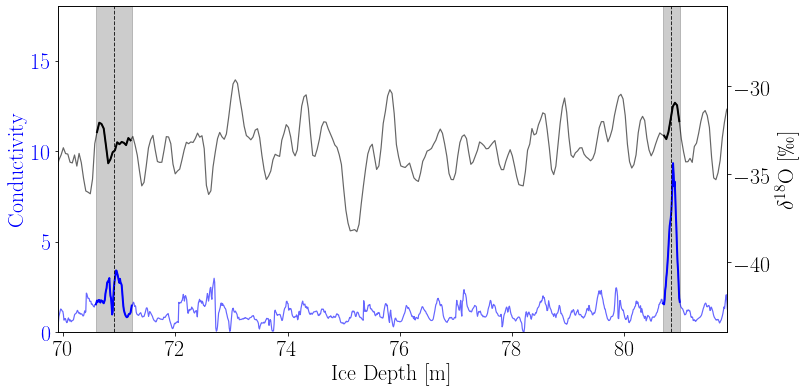

In [27]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(depth_ECM,ECM, lw=1.2, color='b', alpha=0.6)
#ax.plot(depth_ECM_LT, ECM_LT)
ax.plot(depth_ECM_Laki,ECM_Laki, lw=2, color='b')
ax.plot(depth_ECM_Tamb,ECM_Tamb, lw=2, color='b')

ax.set(xlim=(dTamb_in-1, dLaki_in+1), ylim=(0,18), xlabel='Ice Depth [m]')
ax.set_ylabel('Conductivity', color='blue')
ax.tick_params(axis='y', labelcolor='blue')

ax.axvline(x=dTamb_in, ls='--', color='k', alpha=0.8, lw=1)
ax.axvline(x=dLaki_in, ls='--', color='k', alpha=0.8, lw=1)

ax.axvspan(startLaki, endLaki, alpha=0.2, color='k')
ax.axvspan(startTamb, endTamb, alpha=0.2, color='k')






ax_2 = ax.twinx()
ax_2.plot(depth, d18O, lw=1.2, color='k', alpha=0.6)
#ax_2.plot(depth_LT, d18O_LT, color='k', lw=1.2)
ax_2.plot(depth_Laki,d18O_Laki, lw=2, color='k')
ax_2.plot(depth_Tamb,d18O_Tamb, lw=2, color='k')

ax_2.set_ylabel('$\delta^{18}$O [$\permil$]', color='k')
ax_2.tick_params(axis='y', labelcolor='k')

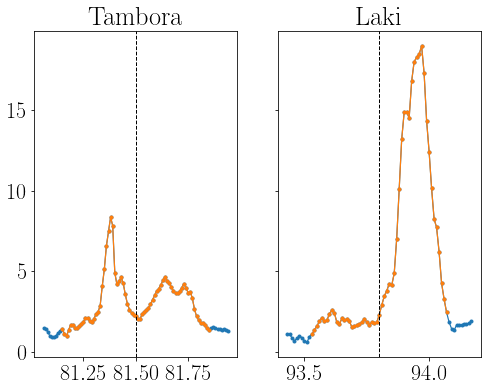

In [134]:
fig, ax = plt.subplots(1,2,figsize=(8,6), sharey=True)

ax[0].plot(depth_ECM_Tamb_Fit,ECM_Tamb_Fit, lw=1.2, marker='.')
ax[0].plot(depth_ECM_Tamb,ECM_Tamb, lw=1.2, marker='.')
ax[0].set(title='Tambora')
ax[0].axvline(x=dTamb_in, lw=1,ls='--',color='k')

ax[1].plot(depth_ECM_Laki_Fit,ECM_Laki_Fit, lw=1.2, marker='.')
ax[1].plot(depth_ECM_Laki,ECM_Laki, lw=1.2,marker='.')
ax[1].set(title='Laki')
ax[1].axvline(x=dLaki_in, lw=1,ls='--',color='k')
#ax.plot(depth_ECM_Tamb,ECM_Tamb, lw=2, color='b')


### Fit Gaussian to peaks

In [121]:
import seaborn as sns                                  # Make the plots nicer to look at
from iminuit import Minuit                             # The actual fitting tool, better than scipy's
from probfit import UnbinnedLH, BinnedLH, Chi2Regression, Extended # Helper tool for fitting
import sys                                             # Modules to see files and folders in directories
from scipy import stats
from scipy.stats import binom, poisson, norm

In [122]:
from external_functions import nice_string_output, add_text_to_ax # useful functions to print fit results on figure

In [123]:
def func_gaussian(x, N, mu, sigma, a):
    return N * norm.pdf(x, mu, sigma) + a



In [124]:
x = depth_ECM_Tamb_Fit
y = ECM_Tamb_Fit

In [127]:
chi2_gaussian = Chi2Regression(func_gaussian, x, y)
minuit_gaussian = Minuit(chi2_gaussian, N=1, mu=73., sigma=0.25, a = 1)
minuit_gaussian.migrad()

<ipython-input-127-8ba658475134>:3: IMinuitWarning: errordef not set, using 1 (appropriate for least-squares)
  minuit_gaussian.migrad()
/usr/local/lib/python3.8/dist-packages/scipy/stats/_distn_infrastructure.py:1836: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0)
/usr/local/lib/python3.8/dist-packages/scipy/stats/_distn_infrastructure.py:1837: RuntimeWarning: invalid value encountered in greater
  cond1 = self._support_mask(x, *args) & (scale > 0)


┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 50.79                      │              Nfcn = 174              │
│ EDM = 1.67e+04 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│INVALID Minimum│ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ ABOVE EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ N     │    1.0    │    0.1    │            │            │         │         │       │
│ 1 │ mu    │   73.00   │   0.21    │            │            │         │         │       │
│ 2 │ sigma │    0.2    │    1.0    │            │            │         │         │       │
│ 3 │ a     │    1.0    │    1.1    │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬─────────────────────────────────┐
│       │       N      mu   sigma       a │
├───────┼─────────────────────────────────┤
│     N │ 0.00997 -0.0157  0.0716  0.0752 │
│    mu │ -0.0157   0.046  -0.208  -0.225 │
│ sigma │  0.0716  -0.208   0.947    1.03 │
│     a │  0.0752  -0.225    1.03    1.12 │
└───────┴─────────────────────────────────┘

In [128]:
vals = minuit_gaussian.values

Ndof_gau = len(x) - 4
Prob_gau = stats.chi2.sf(minuit_gaussian.fval, Ndof_gau)

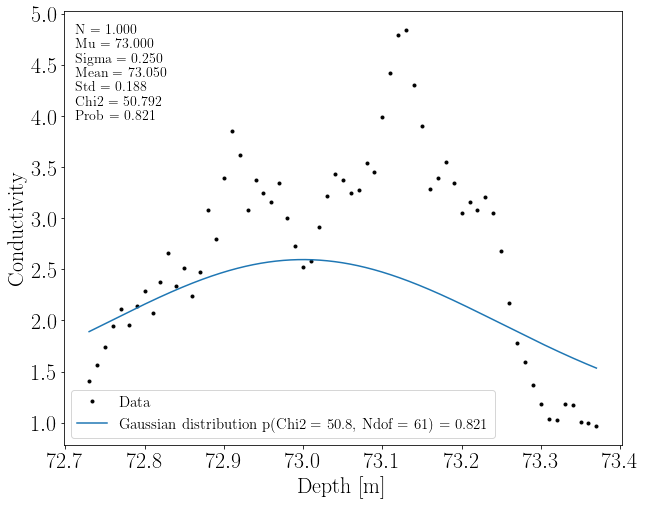

In [129]:
xs = np.linspace(min(x), max(x), 10000)
ys = func_gaussian(xs, vals[0], vals[1], vals[2], vals[3])


fig, ax = plt.subplots(figsize=(10,8))
ax.plot(x, y,'.', c='k', label='Data')
ax.set(xlabel='Depth [m]', ylabel='Conductivity')
ax.plot(xs, ys, '-', label = f'Gaussian distribution p(Chi2 = {minuit_gaussian.fval:.1f}, Ndof = {Ndof_gau:d}) = {Prob_gau:.3f}')

d = {'N = ': minuit_gaussian.values['N'],
     'Mu = ': minuit_gaussian.values['mu'],
     'Sigma = ': minuit_gaussian.values['sigma'],
     'Mean = ': np.mean(x),
     'Std = ': np.std(x),
     'Chi2 = ': minuit_gaussian.fval,
     'Prob = ': Prob_gau,
    }
    
text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.02, 0.97, text, ax, fontsize=14)

ax.legend(fontsize=15)



### Define new random estimate of Laki and Tamb locations

In [22]:
maxTamb = lenTamb/2
maxLaki = lenLaki/2

randTamb = np.random.uniform(-maxTamb, maxTamb)
randLaki = np.random.uniform(-maxLaki, maxLaki)

dTamb = dTamb_in + randTamb
dLaki = dLaki_in + randLaki


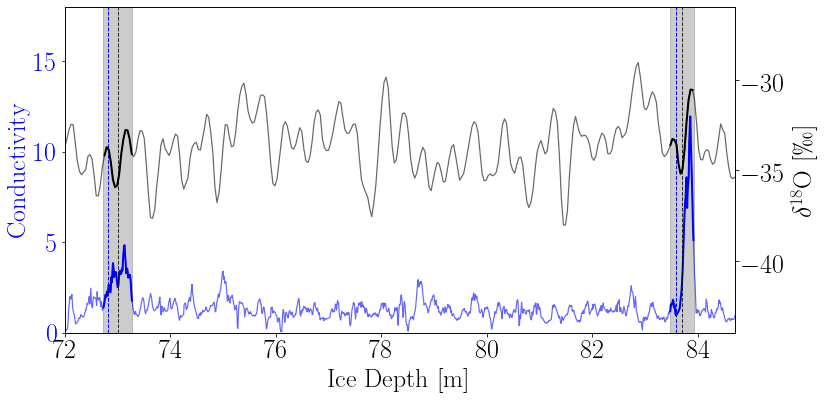

In [23]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(depth_ECM,ECM, lw=1.2, color='b', alpha=0.6)
#ax.plot(depth_ECM_LT, ECM_LT)
ax.plot(depth_ECM_Laki,ECM_Laki, lw=2, color='b')
ax.plot(depth_ECM_Tamb,ECM_Tamb, lw=2, color='b')

ax.set(xlim=(dTamb_in-1, dLaki_in+1), ylim=(0,18), xlabel='Ice Depth [m]')
ax.set_ylabel('Conductivity', color='blue')
ax.tick_params(axis='y', labelcolor='blue')

ax.axvline(x=dTamb_in, ls='--', color='k', alpha=0.8, lw=1)
ax.axvline(x=dTamb, ls='--', color='b', lw=1)

ax.axvline(x=dLaki_in, ls='--', color='k', alpha=0.8, lw=1)
ax.axvline(x=dLaki, ls='--', color='b', lw=1)

ax.axvspan(startLaki, endLaki, alpha=0.2, color='k')
ax.axvspan(startTamb, endTamb, alpha=0.2, color='k')






ax_2 = ax.twinx()
ax_2.plot(depth, d18O, lw=1.2, color='k', alpha=0.6)
#ax_2.plot(depth_LT, d18O_LT, color='k', lw=1.2)
ax_2.plot(depth_Laki,d18O_Laki, lw=2, color='k')
ax_2.plot(depth_Tamb,d18O_Tamb, lw=2, color='k')

ax_2.set_ylabel('$\delta^{18}$O [$\permil$]', color='k')
ax_2.tick_params(axis='y', labelcolor='k')

### Define new sets of data in new LT series

In [24]:
DataAll = GetCoreData(site, 'Alphabet')

data_d18O = DataAll[0]
data_ECM = DataAll[2]
data_dens = DataAll[4]
data_diff = DataAll[6]


depth = data_d18O['depth']
d18O = data_d18O['d18O']

depth_LT = depth[(depth >= dTamb) & (depth <= dLaki)]
d18O_LT = d18O[(depth >= dTamb) & (depth <= dLaki)]



depthDiff = data_diff['Depth']
diff = data_diff['sigma_o18']

depthDiff_LT = depthDiff[(depthDiff >= dTamb) & (depthDiff <= dLaki)]
diff_LT = diff[(depthDiff >= dTamb) & (depthDiff <= dLaki)]



depthDens = data_dens['depth']
dens = data_dens['HLmodel']

depthDens_LT = depthDens[(depthDens >= dTamb) & (depthDens <= dLaki)]
dens_LT = dens[(depthDens >= dTamb) & (depthDens <= dLaki)]


In [25]:
data_dens_LT = pd.DataFrame({'depth': depthDens_LT, 'HLmodel': dens_LT})
data_diff_LT = pd.DataFrame({'Depth': depthDiff_LT, 'sigma_o18': diff_LT})

### Test backdiffusion algorithm


In [26]:
dataAll = pd.DataFrame({'depth':depth_LT,'d18O':d18O_LT}, index=None)

inst = BackDiffuse(site, dataAll, CoresSpecs, dTamb, dLaki, N_InInt, diffLenData=data_diff_LT[['Depth','sigma_o18']], densData=data_dens_LT, Dist=30)

depthOpt, dataOpt, diffLen, peaks, arr_DiffLens, arr_Npeaks, arr_depth, arr_data = inst.backDiffused(theoDiffLen=True,print_Npeaks=False, diffLenStart_In=0.005, diffLenEnd_In=0.15, interpAfterDecon=True)

Sigma fit: 7.60
Min sigma analyt: 7.59
Starting sigma: 5.59 [cm]
100. Npeaks: 33, diffLen: 6.590 cm
Final sigma: 6.65 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.019


In [36]:
from DiffusionProfiles_calculations import sampling_sigma
sampleSize_ave = np.mean(np.diff(depth_LT))
print(f'Average sampling size in interval: {sampleSize_ave:.3f}\n')
sigma_sample = sampling_sigma(sampleSize_ave)
sigma_firn = np.sqrt(diffLen**2 - sigma_sample**2)

print(f'Total diffusion length estimate: \t{diffLen*100:.2f} [cm]')
print(f'Sampling diffusion length estimate: \t{sigma_sample*100:.2f} [cm]')
print(f'Firn diffusion length estimate: \t{sigma_firn*100:.2f} [cm]')


Average sampling size in interval: 0.039

Total diffusion length estimate: 	6.65 [cm]
Sampling diffusion length estimate: 	1.18 [cm]
Firn diffusion length estimate: 	6.55 [cm]


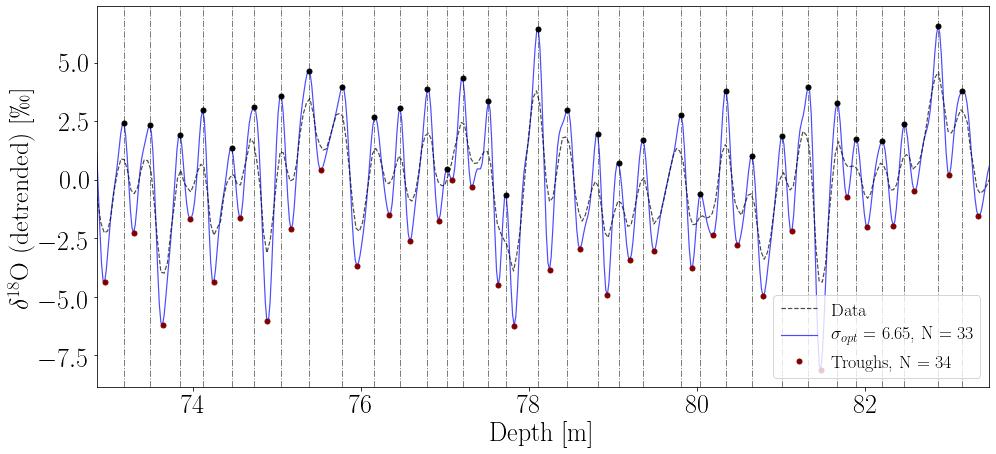

In [27]:
mpl.rcParams['font.size'] = 26

fig, ax = plt.subplots(figsize=(16,7))

plt.plot(np.asarray(depth_LT), np.asarray(d18O_LT)-np.mean(np.asarray(d18O_LT)), lw=1.2, label='Data', ls='--', color='k', alpha=0.7)
plt.plot(depthOpt, dataOpt, label='$\sigma_{opt}$ = ' + f'{diffLen*100:.2f}, N = {len(peaks)}',zorder=-1, color='b', alpha=.7, lw=1.2)

troughs = sp.signal.find_peaks(-dataOpt)[0]
plt.plot(depthOpt[troughs],dataOpt[troughs], '.',color='maroon',ms=10, label=f'Troughs, N = {len(troughs)}')

plt.legend(fontsize=18)
ax.set(xlabel='Depth [m]', ylabel='$\delta^{18}$O (detrended) [$\permil$]',xlim=(min(depthOpt),max(depthOpt)))
plt.scatter(depthOpt[peaks],dataOpt[peaks], color='k',zorder=1, s=25)

for i in range(len(peaks)):
    ax.axvline(depthOpt[peaks[i]],lw=1,color='k',ls='-.',alpha=0.5)
#for i in range(len(troughs)):
#    ax.axvline(depthOpt[troughs[i]],lw=1,color='maroon',ls='--', alpha=0.5)

#fig.savefig('../WrittenWork/Figures/'+site+'_TheoDiffLens.png', bbox_inches='tight')


# Run above code N times

In [ ]:
site = 'SiteB'
N_InInt = 33

CoresSpecs = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/CoreSpecs.txt', ',')

N = 100
diffLens = np.zeros(N)

for i in range(N):
    print(i)
    diffLens[i] = Calc_diffLen_RandLT('SiteA', 33,CoresSpecs)

np.savetxt('Test.csv', diffLens)


# Translate diffusion length estimates to temperature estimates

In [109]:
diffLens = np.array(pd.read_csv('Test.csv', header=None))

array([0.04010122])

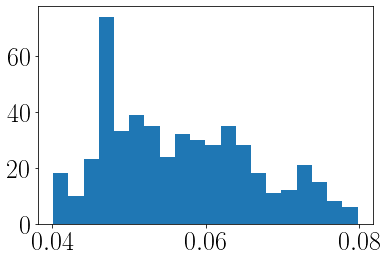

In [119]:

plt.hist(diffLens,20)
np.mean(diffLens)
